#### Imports & Loading Data

In [2]:
import tensorflow as tf
import glob
from PIL import Image
import numpy as np # linear algebra
import pandas as pd
from tensorflow import keras
from tensorflow.keras import preprocessing
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import tensorflow as tf

import os
import pathlib
import time
import datetime
import cv2 as cv
from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output
# import segmentation_models as sm

In [1]:
masked_data_path = "/kaggle/input/photo-recon-train/Masked_Train"
unmasked_data_path = "/kaggle/input/d/raahul42/photo-reconstruction/Dataset/Unmasked_Train"
test_dataset = "/kaggle/input/d/raahul42/photo-reconstruction/Dataset/Testing_Data"

In [3]:
masked_data = keras.utils.image_dataset_from_directory(directory=masked_data_path, batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
unmasked_data = keras.utils.image_dataset_from_directory(directory=unmasked_data_path, batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
test_dataset = keras.utils.image_dataset_from_directory(directory=test_dataset, batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
file_paths = test_dataset.file_paths

Found 7000 files belonging to 1 classes.
Found 7000 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


In [4]:
dataset = tf.data.Dataset.zip((masked_data, unmasked_data))
file_paths[:5]

['/kaggle/input/d/raahul42/photo-reconstruction/Dataset/Testing_Data/Cat-Train (1).png',
 '/kaggle/input/d/raahul42/photo-reconstruction/Dataset/Testing_Data/Cat-Train (100).jpeg',
 '/kaggle/input/d/raahul42/photo-reconstruction/Dataset/Testing_Data/Cat-Train (1065).jpeg',
 '/kaggle/input/d/raahul42/photo-reconstruction/Dataset/Testing_Data/Cat-Train (11).jpg',
 '/kaggle/input/d/raahul42/photo-reconstruction/Dataset/Testing_Data/Cat-Train (1110).jpeg']

In [5]:
train_size = int(0.8*dataset.cardinality().numpy())

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [6]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(normalize, num_parallel_calls=AUTOTUNE)

In [8]:
# Normalizing the images to [-1, 1]
def normalize_test(input_image):
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1

    return input_image
test_dataset = test_dataset.map(normalize_test, num_parallel_calls=AUTOTUNE)

In [9]:
AUTOTUNE 

-1

### Defining Model

In [10]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


#### Generator

In [12]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


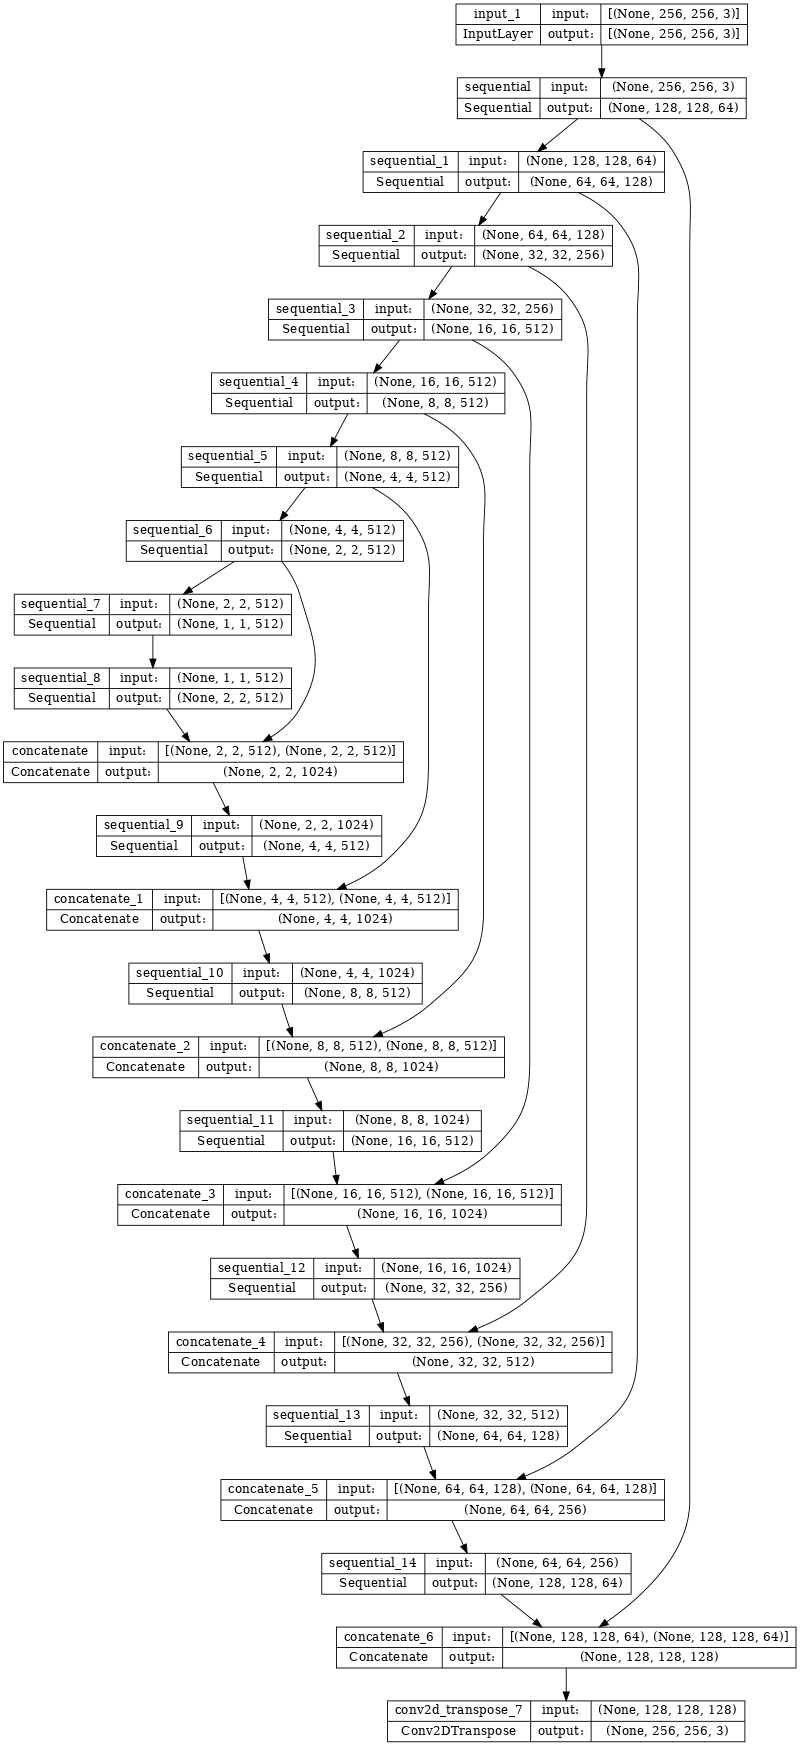

In [13]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


#### Discriminator

In [14]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


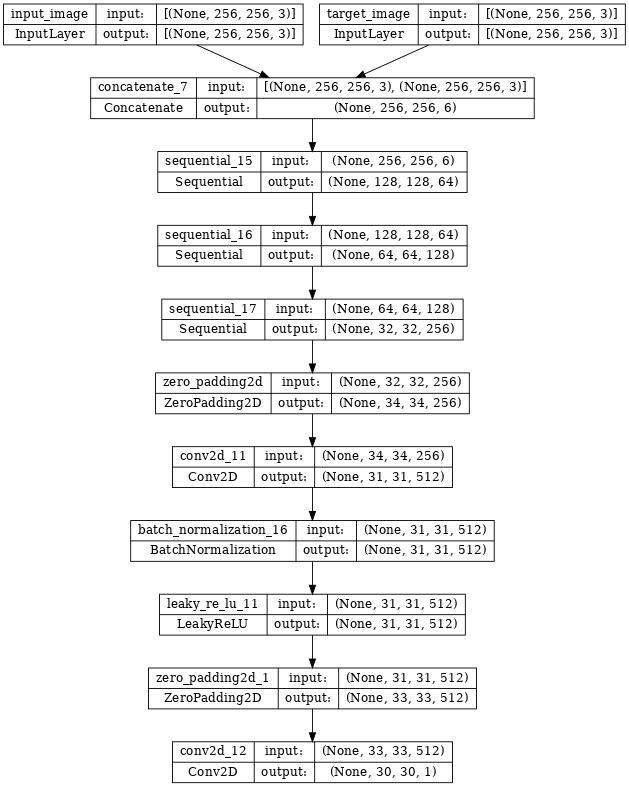

In [15]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


In [16]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [17]:
generator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)


In [18]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()



### Train Function

In [21]:
@tf.function
def train_step(input_image, target, step):
    print(step)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


In [22]:
LAMBDA = 100

In [23]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [25]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")
        
        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 10k steps
        if (step + 1) % 10000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


In [26]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


### Training

Time taken for 1000 steps: 53.77 sec



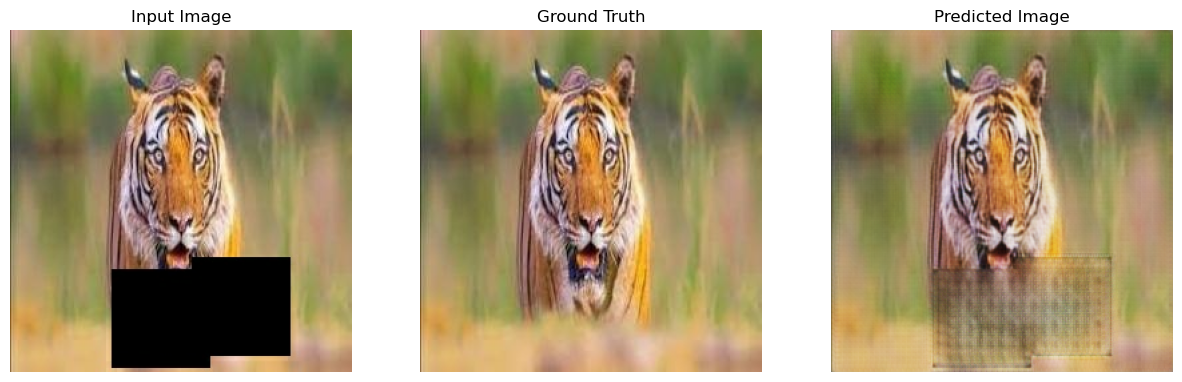

Step: 29k
....................................................................................................

In [28]:
fit(train_dataset, val_dataset, steps=30000)

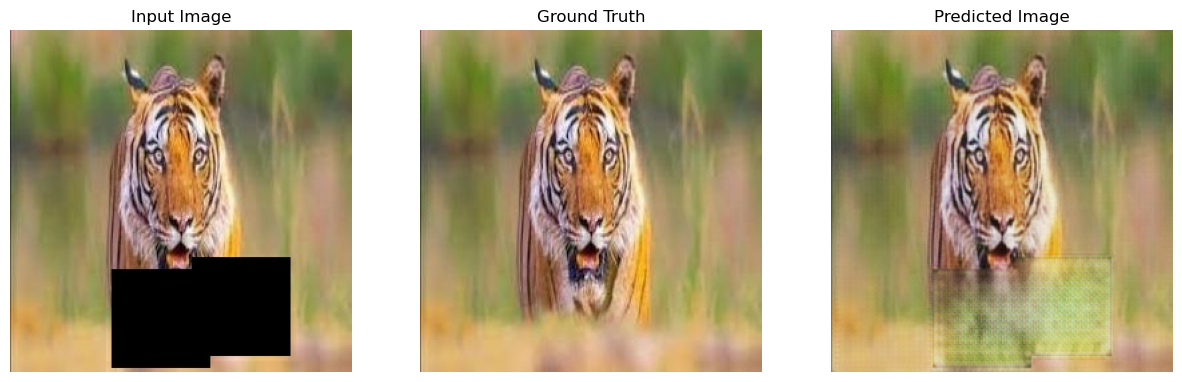

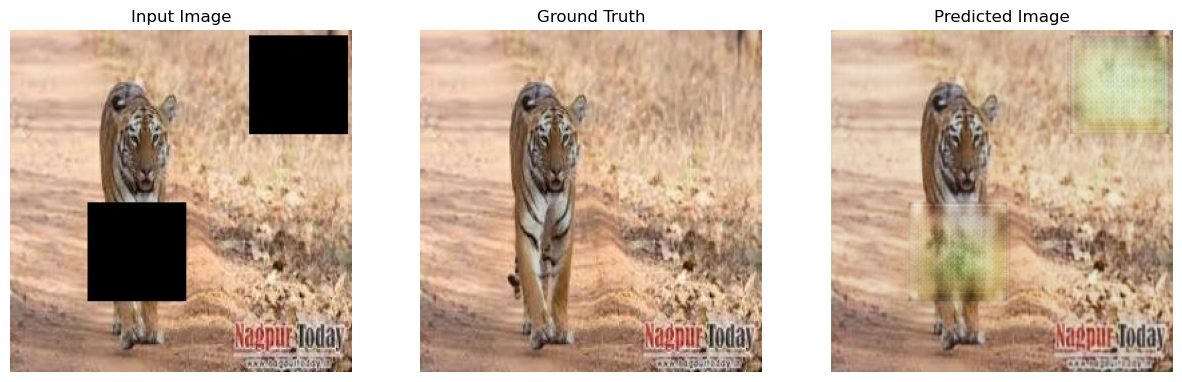

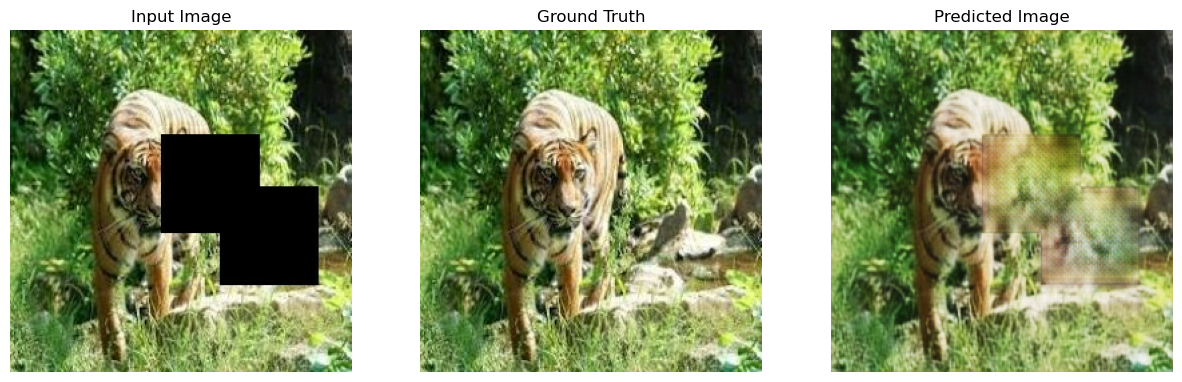

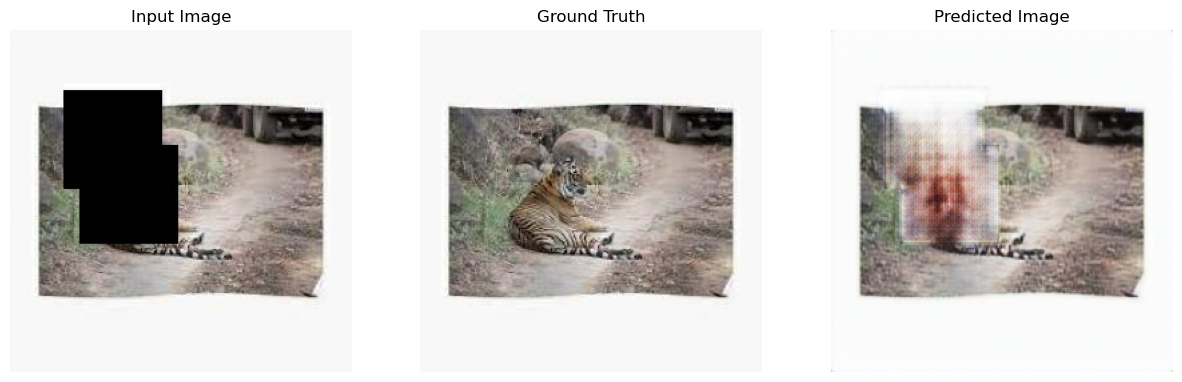

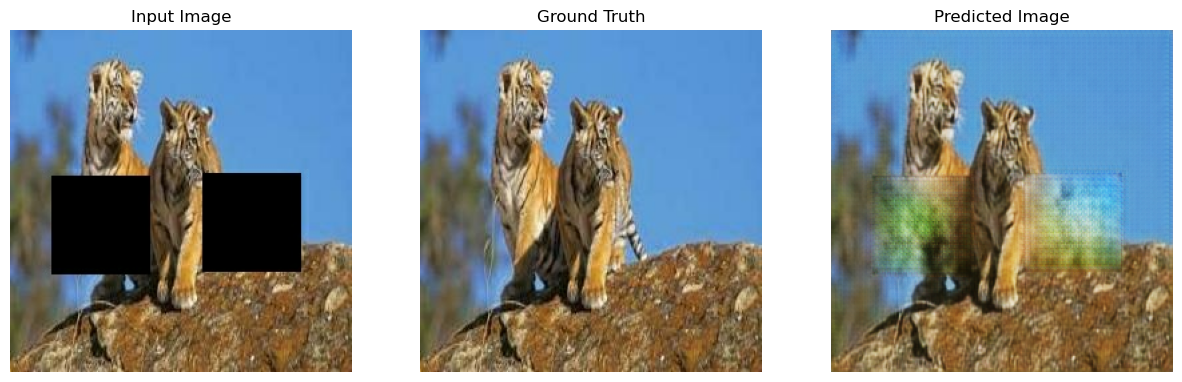

In [29]:
# Run the trained model on a few examples from the validation set
for inp, tar in val_dataset.take(5):
    generate_images(generator, inp, tar)

In [30]:
def generate_test_images(model, test_input):
    prediction = model(test_input, training=True)
    return(prediction[0])

### Test & Submission File

In [61]:
test_path = "/kaggle/input/photo-reconstruction/Dataset/Testing_Data"
test_mask_data = pd.read_csv(test_path + '/masked_info.csv').drop(['Unnamed: 0'],axis=1)
test_mask_data[test_mask_data['filename']==file_paths[1].split('/')[-1]].iloc[0,:]

filename    Cat-Train (100).jpeg
box1_row                     136
box1_col                      67
box2_row                      84
box2_col                     165
Name: 46, dtype: object

In [62]:
def submission_data(test_path):
    test_mask_data = pd.read_csv(test_path + '/masked_info.csv').drop(['Unnamed: 0'],axis=1)
    submission = []
    for i, img in enumerate(test_dataset):
        filename = file_paths[i].split('/')[-1]
        y1, x1, y2, x2 = test_mask_data[test_mask_data['filename']==filename].iloc[0,1:]
        tensor_array = generate_test_images(generator, img)
        im = np.array(tensor_array)
        b, g, r = cv.split(im)
        result = np.zeros((256, 256))
        normalized_b = cv.normalize(b,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        normalized_g = cv.normalize(g,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        normalized_r = cv.normalize(r,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        for i in range(y1 , y1+75):
            for j in range(x1, x1+75):
                temp1 = filename + '_' + 'box1' + '_' +  str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', normalized_b[i,j]))
                submission.append((temp1 + '1', normalized_g[i,j]))
                submission.append((temp1 + '2', normalized_r[i,j]))
        for i in range(y2 , y2+75):
            for j in range(x2, x2+75):
                temp1 = filename + '_' + 'box2' + '_' + str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', normalized_b[i,j]))
                submission.append((temp1 + '1', normalized_g[i,j]))
                submission.append((temp1 + '2', normalized_r[i,j]))
        df = pd.DataFrame(submission, columns=['filename_box_pixel','value'])
    return(df)

In [63]:
df = submission_data(test_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750000 entries, 0 to 6749999
Data columns (total 2 columns):
 #   Column              Dtype  
---  ------              -----  
 0   filename_box_pixel  object 
 1   value               float32
dtypes: float32(1), object(1)
memory usage: 77.2+ MB


In [64]:
df

filename_box_pixel     value
0        Cat-Train (1).png_box1_57_171_0  0.840683
1        Cat-Train (1).png_box1_57_171_1  0.680077
2        Cat-Train (1).png_box1_57_171_2  0.335006
3        Cat-Train (1).png_box1_57_172_0  0.883155
4        Cat-Train (1).png_box1_57_172_1  0.779133
...                                  ...       ...
6749995  Tiger (990).jpeg_box2_205_248_1  0.300476
6749996  Tiger (990).jpeg_box2_205_248_2  0.768565
6749997  Tiger (990).jpeg_box2_205_249_0  0.101597
6749998  Tiger (990).jpeg_box2_205_249_1  0.370994
6749999  Tiger (990).jpeg_box2_205_249_2  0.825797

[6750000 rows x 2 columns]

In [65]:
df.to_csv("pix2pix-40k.csv",index=False)